# Create multi-element airfoil data

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

In [2]:
PATH_DATA = Path("../data/coordinates")
list(PATH_DATA.glob("*"))

[PosixPath('../data/coordinates/.DS_Store'),
 PosixPath('../data/coordinates/body.png'),
 PosixPath('../data/coordinates/slot.png'),
 PosixPath('../data/coordinates/cove.png'),
 PosixPath('../data/coordinates/cove.csv'),
 PosixPath('../data/coordinates/processed'),
 PosixPath('../data/coordinates/raw')]

In [3]:
# Paths
path_raw = PATH_DATA / "raw"
path_processed = PATH_DATA / "processed"

## Scale raw data

In [4]:
COVE_NAME = "cove_smooth"

names = ["main", "slot", COVE_NAME]

# Operations
X_LOWER = "X_lower"
X_UPPER = "X_upper"
Y_LOWER = "Y_lower"
Y_UPPER = "Y_upper"

In [5]:
coordinates = dict()
for name in names:

    _name = name + ".csv"
    _coordinates = pd.read_csv(path_raw / _name)
    
    # Scale
    _coordinates = _coordinates.div(100.0).round(6)
    
    # Repanel
    _coordinates

    # Save
    coordinates[name] = _coordinates.copy()
    
    _coordinates.to_csv(path_or_buf = path_processed / _name , index=False)

## Build airfoils

In [6]:
main = coordinates["main"]
cove = coordinates[COVE_NAME]

### Main element

#### Lower surface

In [7]:
main_lower = main.filter(regex="lower")
cove_lower = cove.filter(regex="lower")

In [8]:
min_x = cove_lower[X_LOWER].min()
mask = main_lower[X_LOWER] < min_x

main_lower = main_lower.loc[mask].append(cove_lower).set_index(X_LOWER)

#### Upper surface

In [10]:
main_upper = main.filter(regex="upper")
cove_upper = cove.filter(regex="upper")

In [11]:
min_x = cove_upper[X_UPPER].min()
mask = main_upper[X_UPPER] < min_x

main_upper = main_upper.loc[mask].append(cove_upper).set_index(X_UPPER)

# Fill in the gaps
main_upper = main_upper.reset_index(drop=False).dropna(subset=[X_UPPER]).set_index(X_UPPER)
main_upper = main_upper.interpolate(method="index")

#### Combine upper and lower surface

In [12]:
def interpolate_series(series, N):
    """Interpolate series to higher frequency.

    Parameters
    ----------
    series : pandas.Series
    N : int

    Returns
    -------
    series : interpolated series
    """

    _series = series.copy()

    grad = series.index.values[0] - series.index.values[-1]
    ascending = grad < 0

    index = _series.index
    start = index[0]
    stop = index[-1]

    new_index = np.linspace(start=start, stop=stop, num=N)
    new_index = pd.Index(new_index[1:-1])

    _series = _series.reindex(new_index.append(index))
    _series = _series.sort_index(ascending=ascending)
    _series = _series.interpolate(method="index")

    return _series

In [13]:
# Clean
main_lower = main_lower.dropna().drop_duplicates().sort_index(ascending=False)
main_upper = main_upper.dropna().drop_duplicates().sort_index(ascending=True)

# Interpolate
# N_UPPER = 50
# N_LOWER = 60

# main_lower = interpolate_series(main_lower, N = N_LOWER)
# main_upper = interpolate_series(main_upper, N = N_UPPER)

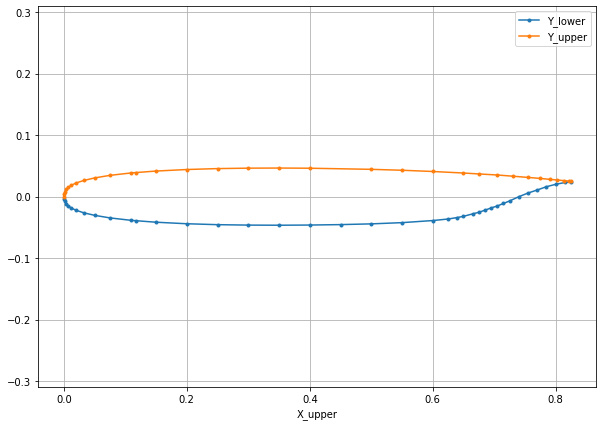

In [14]:
ax = main_lower.plot(marker = ".")
main_upper.plot(ax=ax,marker = ".")

plt.axis("equal")
plt.grid()

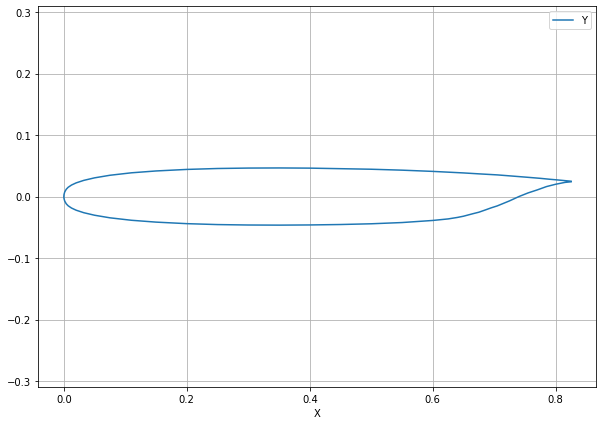

In [15]:
concat = np.concatenate([main_lower.reset_index().values, main_upper.reset_index().values])
coordinates_main = pd.DataFrame(concat, columns = ["X", "Y"])

coordinates_main.set_index("X").plot()

plt.axis('equal')
plt.grid()

In [16]:
x = 0.6895

In [17]:
mask = main_upper.index < x

In [18]:
main_upper.squeeze().loc[mask].tail(1)

X_upper
0.675    0.0369
Name: Y_upper, dtype: float64

In [19]:
main_upper.loc[[main_upper.squeeze() < x][-1]]

,Y_upper
X_upper,
0.00000,0.00000
0.00035,0.00350
0.00150,0.00750
0.00400,0.01185
0.00700,0.01500
0.01250,0.01870
0.02000,0.02220
0.03250,0.02630
0.05000,0.03040


In [20]:
coordinates_main.to_csv(
    path_or_buf=path_processed / "main_element.csv", index=False, sep="\t"
)

### Flap element

In [21]:
slot = coordinates["slot"]

In [22]:
slot_lower = slot.filter(regex="lower")
slot_upper = slot.filter(regex="upper")

In [23]:
slot_lower = slot_lower.set_index(X_LOWER)
slot_upper = slot_upper.set_index(X_UPPER)

In [24]:
slot_lower = slot_lower.dropna().drop_duplicates().sort_index(ascending=False)
slot_upper = slot_upper.dropna().drop_duplicates().sort_index(ascending=True)

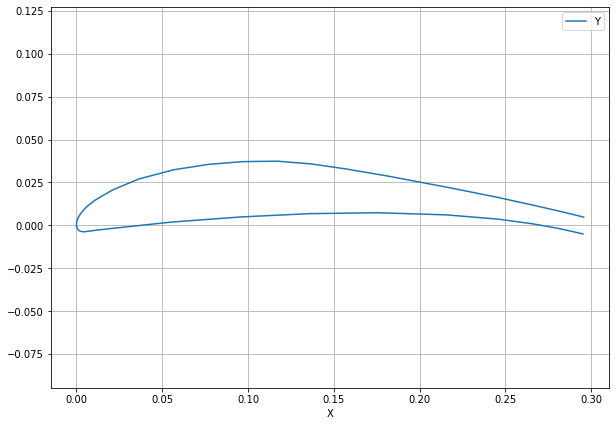

In [26]:
concat = np.concatenate([slot_lower.reset_index().values, slot_upper.reset_index().values])
coordinates_slot = pd.DataFrame(concat, columns = ["X", "Y"])

coordinates_slot.set_index("X").plot()

plt.axis("equal")
plt.grid()

In [27]:
coordinates_slot.to_csv(
    path_or_buf=path_processed / "flap.dat", index=False, sep="\t"
)